# K-Means Clustering and Principal Component Analysis

In [1]:
import colorsys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import scipy.io
import seaborn.apionly as sns

In [21]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

## K-Means

In [22]:
mat = scipy.io.loadmat('ex7/ex7data2.mat')
X = mat['X']

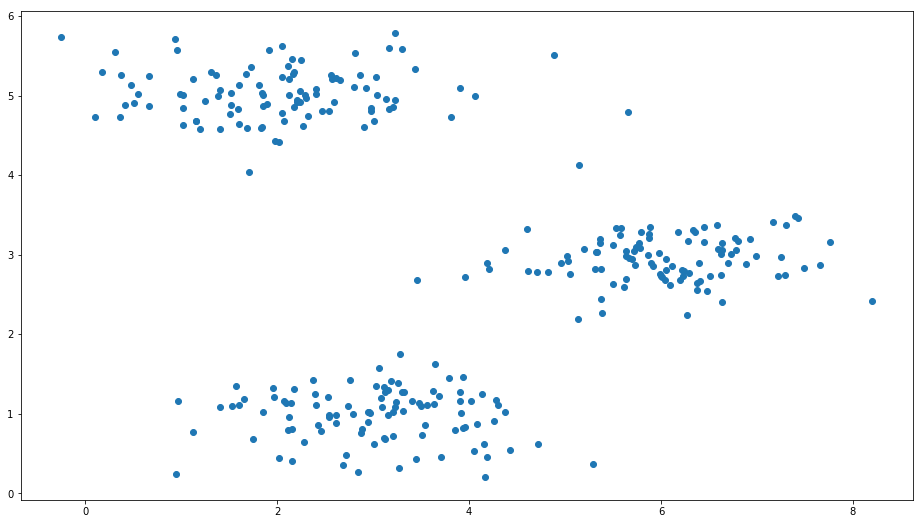

In [23]:
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], marker='o')

plt.show()

In [24]:
def find_closest_centroids(X, C):
    return np.argmin(np.linalg.norm(X[:, np.newaxis] - C, axis=2), axis=1)

In [25]:
K = 3
C = np.array([[3, 3], [6, 2], [8, 5]])

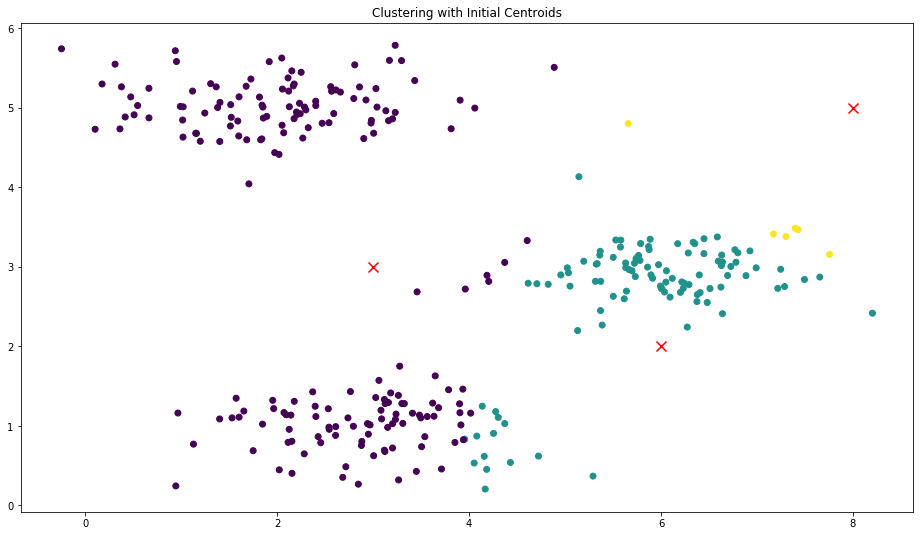

In [26]:
idx = find_closest_centroids(X, C)

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], marker='o', c=idx)
ax.scatter(C[:,0], C[:,1], marker='x', s=100, c='r')
plt.title('Clustering with Initial Centroids')
plt.show()

In [27]:
def compute_centroids(X, idx, K):
    return np.array([np.mean(X[idx==i], axis=0) for i in range(K)])

In [28]:
def k_means(X, K, C, max_iters, save_history=False):
    '''
    Assign points to centroids, then recompute 
    mean coordinate of points assigned to centroid
    Repeat max_iters times.
    '''
    history = []
    if save_history:
        history = [[C[i]] for i in range(len(C))]
    for _ in range(max_iters):
        idx = find_closest_centroids(X, C)
        C = compute_centroids(X, idx, K)
        if save_history:
            for i in range(len(C)):
                history[i].append(C[i])
    return idx, C, history

In [29]:
idx, centroids, history = k_means(X, K, C, 10, save_history=True)

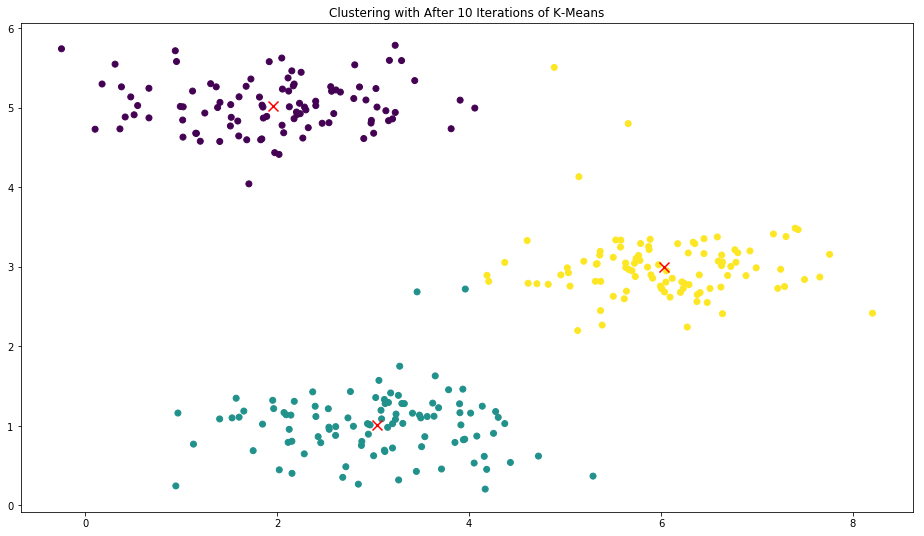

In [30]:
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], marker='o', c=idx)
ax.scatter(centroids[:,0], centroids[:,1], marker='x', s=100, c='r')
plt.title('Clustering with After 10 Iterations of K-Means')
plt.show()

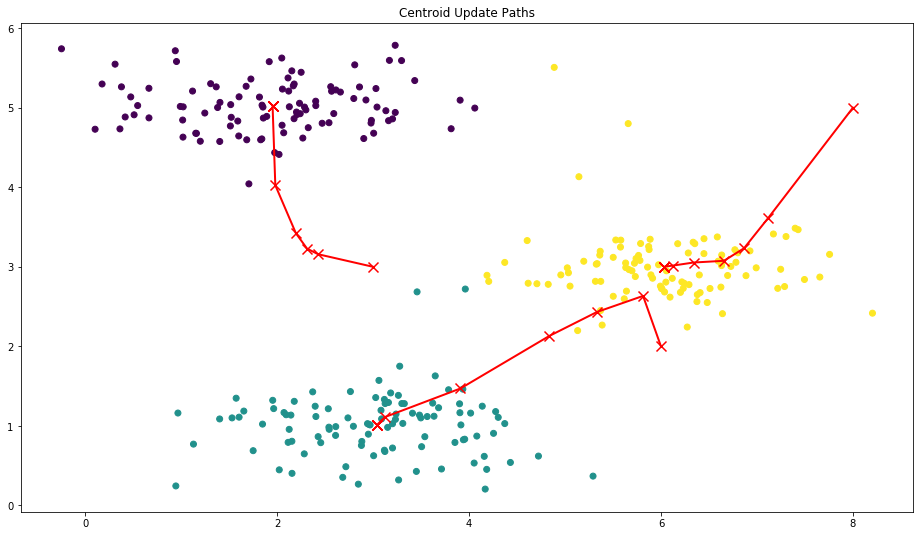

In [31]:
fig, ax = plt.subplots()

ax.scatter(X[:,0], X[:,1], marker='o', c=idx)
for i in range(len(history)):
    c = np.array(history[i])
    ax.plot(c[:,0], c[:,1], linestyle='-', c='r', linewidth=2)
    ax.scatter(c[:,0], c[:,1], marker='x', s=100, c='r')

plt.title('Centroid Update Paths')
plt.show()

## K-Means on Pixels

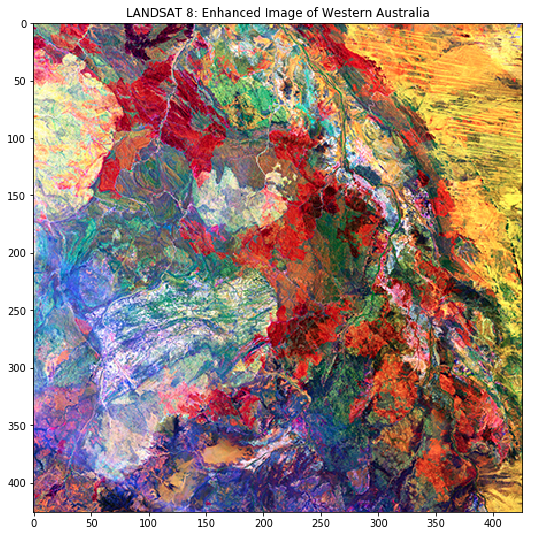

In [40]:
A = plt.imread('ex7/landsat.png')
plt.imshow(A)
plt.title('LANDSAT 8: Enhanced Image of Western Australia')
plt.show()

In [33]:
A.shape

(426, 426, 4)

In [34]:
A_reshaped = np.reshape(A, (A.shape[0] * A.shape[1], A.shape[2]))

In [56]:
A_reshaped.shape

(181476, 4)

In [59]:
print(f'The original image has {len(np.unique(A_reshaped, axis=0))} unique color values')

The original image has 164692 unique color values


In [104]:
def hsv_sort(X):
    s = sorted(X, key=lambda rgb: colorsys.rgb_to_hsv(*rgb[:3]))
    return np.array(s)

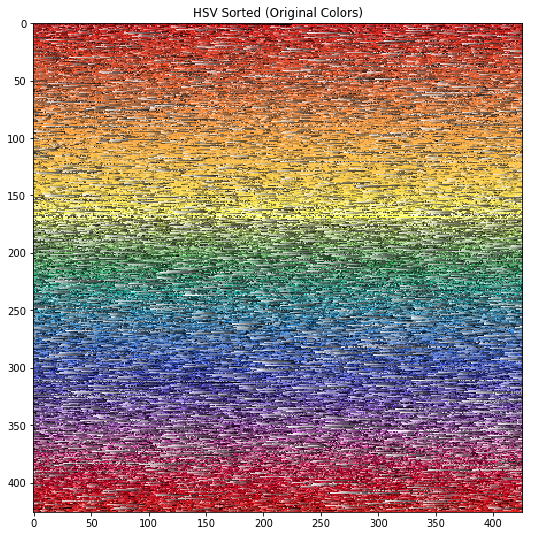

In [117]:
A_sorted = hsv_sort(A_reshaped)
plt.imshow(np.reshape(A_sorted, A.shape))
plt.title('HSV Sorted (Original Colors)')
plt.show()

In [35]:
def k_means_init_centroid(X, K):
    '''Picks K random points from X as initial centroids'''
    randidx = np.random.choice(range(X.shape[0]), K)
    centroids = X[randidx]
    return centroids

In [102]:
def k_means_image(X, K, dims):
    '''
    Runs K-means on X with K centroids
    Returns reshaped to dims
    '''
    C = k_means_init_centroid(X, K)
    idx, C, _ = k_means(X, K, C, 10)
    B = np.empty_like(X)
    for i in range(B.shape[0]):
        B[i,:] = C[idx[i]]
    return B

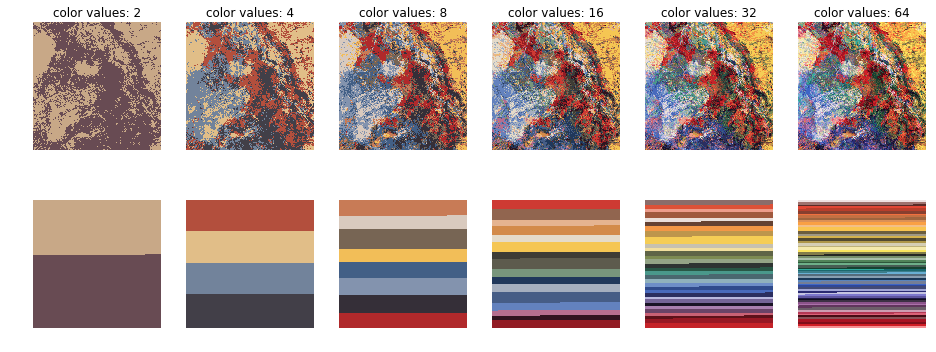

In [248]:
fig, axs = plt.subplots(2, 6, figsize=(16, 6))

for i in range(6):
    image = k_means_image(A_reshaped, 2 ** (i + 1), A.shape)
    image_sorted = hsv_sort(image)

    ax = axs[0][i]
    ax.axis('off')
    ax.set_title(f'color values: {2 ** (i + 1)}')
    ax.imshow(np.reshape(image, A.shape))

    ax = axs[1][i]
    ax.axis('off')
    ax.imshow(np.reshape(image_sorted, A.shape))

plt.show()

## PCA

In [118]:
mat = scipy.io.loadmat('ex7/ex7data1.mat')
X = mat['X']

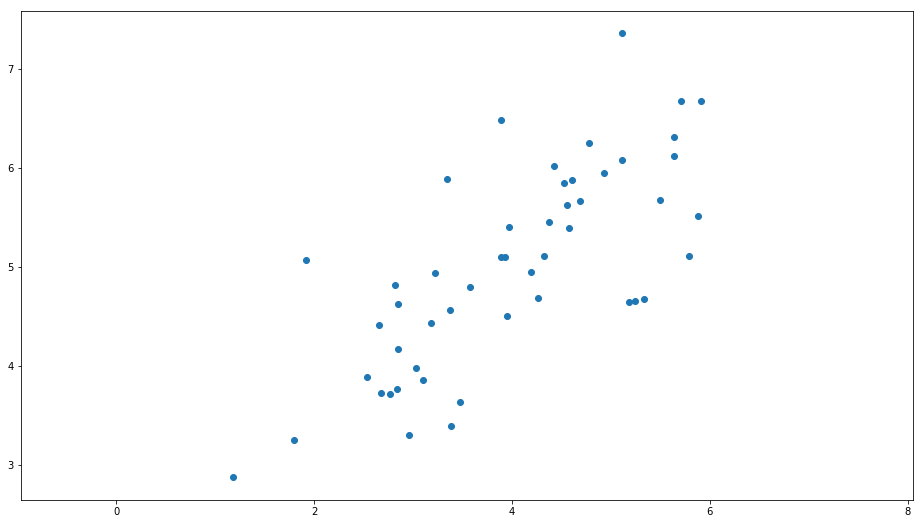

In [119]:
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], marker='o')
plt.axis('equal')
plt.show()

In [120]:
def normalize(X):
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_norm = (X - X_mean) / X_std
    return X_norm, X_mean, X_std

In [121]:
X_norm, X_mean, X_std = normalize(X)

In [122]:
def pca(X):
    m, n = X.shape
    sigma = np.dot(X.T, X) / m
    U, S, V = np.linalg.svd(sigma)
    return U, S, V

In [123]:
U, S, V = pca(X_norm)

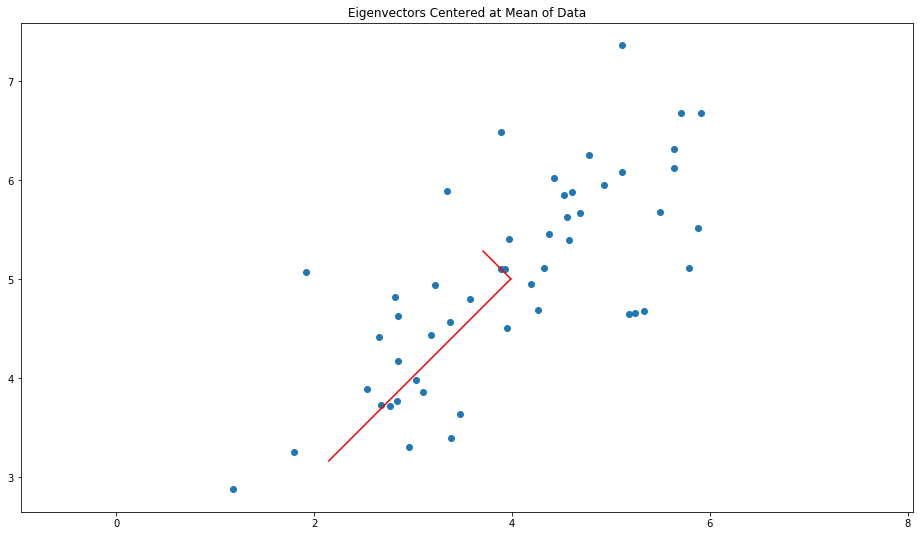

In [124]:
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], marker='o')

x, y = X_mean + 1.5 * S[0] * U[0,:]
ax.plot([X_mean[0], x], [X_mean[1], y], c='r')

x, y = X_mean + 1.5 * S[1] * U[1,:]
ax.plot([X_mean[0], x], [X_mean[1], y], c='r')

plt.title('Eigenvectors Centered at Mean of Data')
plt.axis('equal')
plt.show()

In [125]:
def project_data(X, U, K):
    '''computes the projection of 
    the normalized inputs X into the reduced dimensional space spanned by
    the first K columns of U.'''
    return np.dot(X, U)[:,:K]

In [126]:
K = 1
Z = project_data(X_norm, U, K)

In [127]:
def recover_data(Z, U, K):
    '''recovers an approximation the 
    original data that has been reduced to K dimensions.'''
    return np.dot(Z, U[:,:K].T)

In [128]:
X_rec = recover_data(Z, U, K)

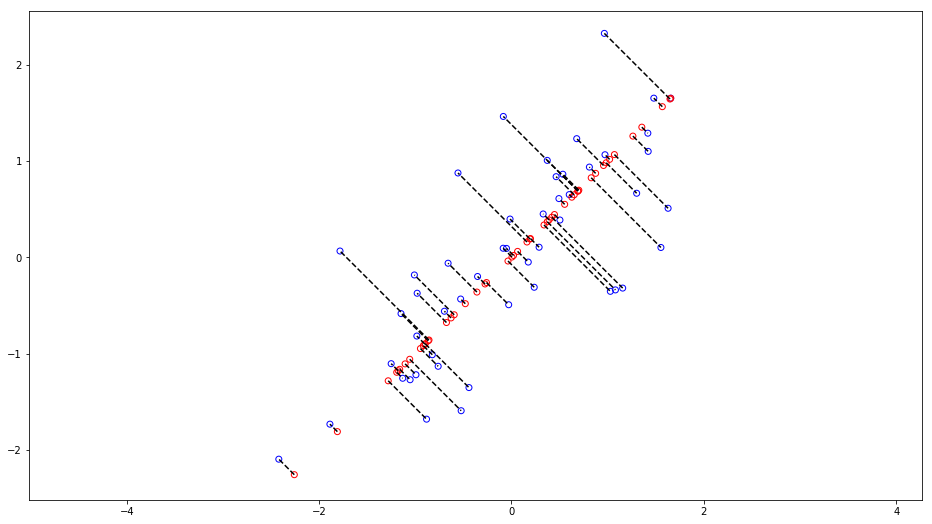

In [129]:
fig, ax = plt.subplots()
ax.scatter(X_norm[:,0], X_norm[:,1], marker='o', facecolors='none', edgecolors='b')
ax.scatter(X_rec[:,0], X_rec[:,1], marker='o', facecolors='none', edgecolors='r')
for i in range(X.shape[0]):
    ax.plot([X_rec[i,0], X_norm[i,0]], [X_rec[i,1], X_norm[i,1]], 'k--') 
plt.axis('equal')
plt.show()

## PCA on Pixels

In [234]:
mat = scipy.io.loadmat('ex7/ex7faces.mat')
X = mat['X']

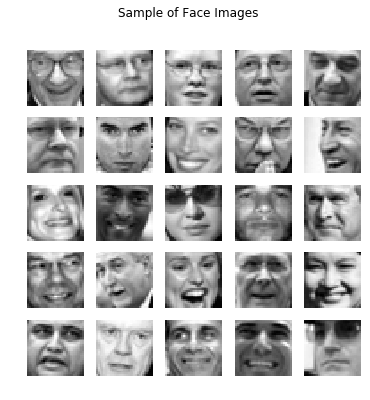

In [238]:
fig, axs = plt.subplots(5, 5, figsize=(6, 6))
axs = axs.flatten()

for i in range(25):
    axs[i].axis('off')
    image = np.reshape(X[i,:], (32, 32)).T
    axs[i].imshow(image, cmap='gray')

plt.suptitle('Sample of Face Images')
plt.show()

In [239]:
K = 100
X_norm, X_mean, X_std = normalize(X)
U, S, V = pca(X_norm)

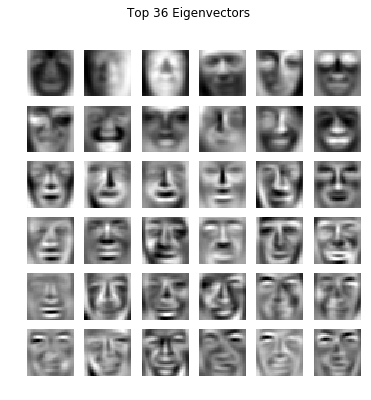

In [240]:
fig, axs = plt.subplots(6, 6, figsize=(6, 6))
axs = axs.flatten()

for i in range(36):
    axs[i].axis('off')
    image = np.reshape(U[:,i], (32, 32)).T
    axs[i].imshow(image, cmap='gray')

plt.suptitle('Top 36 Eigenvectors')
plt.show()

In [241]:
Z = project_data(X_norm, U, K)
print('The projected data Z has a size of', Z.shape)

The projected data Z has a size of (5000, 100)


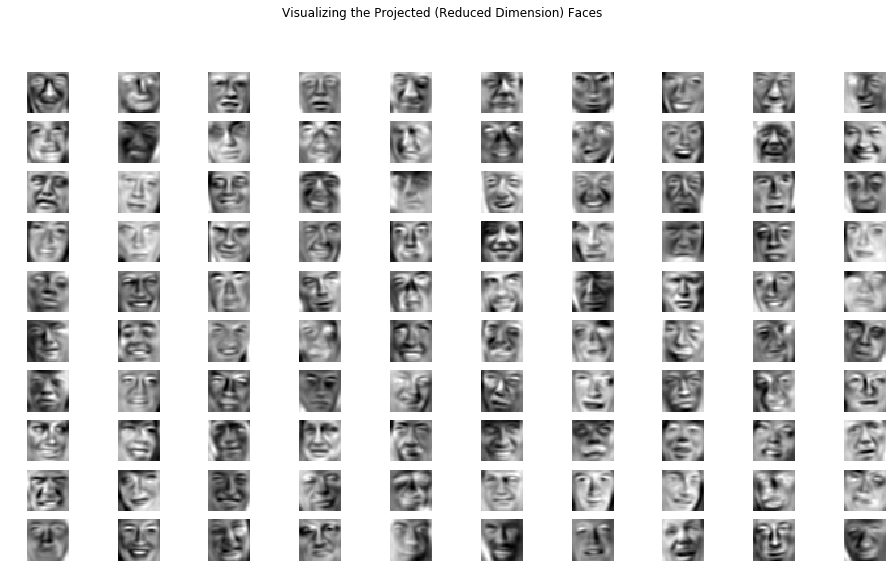

In [243]:
X_rec = recover_data(Z, U, K)

fig, axs = plt.subplots(10, 10)
axs = axs.flatten()

for i in range(100):
    axs[i].axis('off')
    image = np.reshape(X_rec[i,:], (32, 32)).T
    axs[i].imshow(image, cmap='gray')

plt.suptitle('Visualizing the Projected (Reduced Dimension) Faces')
plt.show()

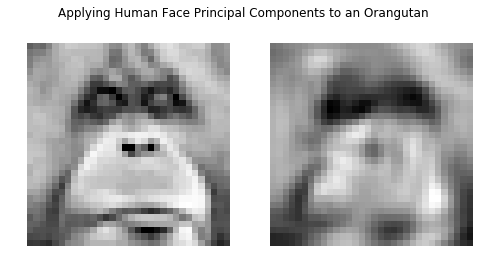

In [263]:
O = plt.imread('ex7/orangutan_small.png')[:,:,:1]
O_reshaped = np.reshape(O, (O.shape[0] * O.shape[1], O.shape[2]))

O_norm, O_mean, O_std = normalize(orangutan_reshaped)
Z = project_data(O_norm.T, U, K)
O_rec = recover_data(Z, U, K)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.reshape(O_reshaped, (32, 32)), cmap='gray')
axs[0].axis('off')
axs[1].imshow(np.reshape(O_rec.T, (32, 32)), cmap='gray')
axs[1].axis('off')

plt.suptitle('Applying Human Face Principal Components to an Orangutan')
plt.show()

## PCA for Visualization

In [45]:
A = plt.imread('ex7/bird_small.png')
A = A / 255
A_reshaped = np.reshape(A, (A.shape[0] * A.shape[1], A.shape[2]))

In [46]:
K = 16
max_iters = 10
initial_centroids = k_means_init_centroid(A_reshaped, K)
idx, centroids, _ = k_means(A_reshaped, K, initial_centroids, max_iters)

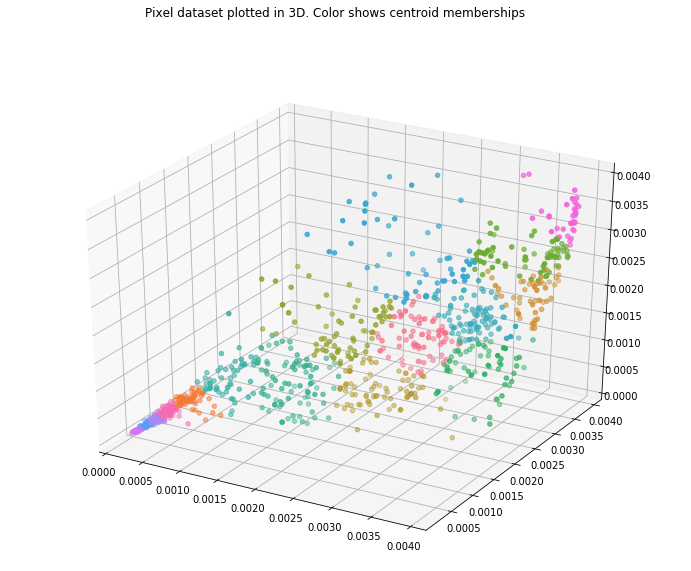

In [63]:
cmap = ListedColormap(sns.color_palette('husl', 16))

randidx = np.random.choice(range(A_reshaped.shape[0]), 1000)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(A_reshaped[randidx,0],
           A_reshaped[randidx,1],
           A_reshaped[randidx,2],
           marker='o',
           c=idx[randidx],
           cmap=cmap)

plt.suptitle('Pixel dataset plotted in 3D. Color shows centroid memberships')
plt.show()

In [49]:
A_norm, A_mean, A_std = normalize(A_reshaped)
U, S, V = pca(A_norm)
Z = project_data(A_norm, U, 2)

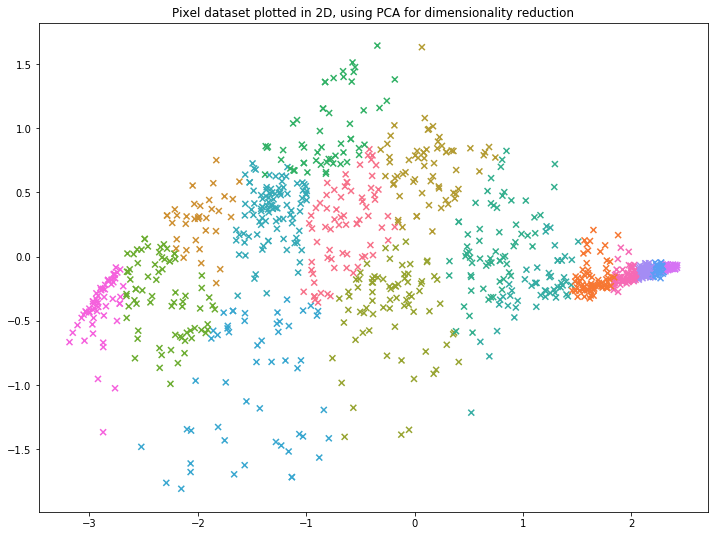

In [61]:
fig, ax = plt.subplots()
ax.scatter(Z[randidx][:,0], Z[randidx][:,1], marker='x', c=idx[randidx], cmap=cmap)
plt.title('Pixel dataset plotted in 2D, using PCA for dimensionality reduction')
plt.show()